# Melanoma classification with PyTorch Lightning

Using EfficientNet on PyTorch Lightning, with its amazing hardware agnostic and mixed precision implementation.

This is still work in progress, so please bear with me

In [ ]:
# import os
# assert os.environ['COLAB_TPU_ADDR']

In [ ]:
# %%capture
# VERSION = "20200325"
# #!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python3 pytorch-xla-env-setup.py --version $VERSION

In [1]:
fold_number = 3
tta   = 20

batch_size = {
    'tpu': 8, # x8
    'gpu': 16, # 10 without AMP
    'cpu': 4,
}

arch = 'efficientnet-b5'
resolution = 456  # orignal res for B5
input_res  = 512

lr = 1e-5   # * batch_size
weight_decay = 2e-5
pos_weight   = 3.2
label_smoothing = 0.03

max_epochs = 4
%reload_ext autoreload
%autoreload 2

In [2]:
#!pip install --upgrade wandb
#!wandb login 6ff8d5e5bd920e68d1f76b574f1880278b4ac8d2

# Install modules

Update PyTorch to enable its native support to Mixed Precision or XLA for TPU

In [3]:
# import wandb
# from pytorch_lightning.loggers import WandbLogger

# Hardware lookup

In [4]:
# import os
# import collections
# from datetime import datetime, timedelta

# if 'TPU_NAME' in os.environ.keys():
    
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#       python3 pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

#     os.environ["XRT_TPU_CONFIG"] = "tpu_worker;0;10.0.0.2:8470"

#     _VersionConfig = collections.namedtuple('_VersionConfig', 'wheels,server')
#     VERSION = "torch_xla==nightly"
#     CONFIG = {
#         'torch_xla==nightly': _VersionConfig('nightly', 'XRT-dev{}'.format(
#             (datetime.today() - timedelta(1)).strftime('%Y%m%d')))}[VERSION]

#     DIST_BUCKET = 'gs://tpu-pytorch/wheels'
#     TORCH_WHEEL = 'torch-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)
#     TORCH_XLA_WHEEL = 'torch_xla-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)
#     TORCHVISION_WHEEL = 'torchvision-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)

#     !export LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH
#     !apt-get install libomp5 -y
#     !apt-get install libopenblas-dev -y

#     !pip3 uninstall -y torch torchvision
#     !gsutil cp "$DIST_BUCKET/$TORCH_WHEEL" .
#     !gsutil cp "$DIST_BUCKET/$TORCH_XLA_WHEEL" .
#     !gsutil cp "$DIST_BUCKET/$TORCHVISION_WHEEL" .
#     !pip3 install "$TORCH_WHEEL"
#     !pip3 install "$TORCH_XLA_WHEEL"
#     !pip3 install "$TORCHVISION_WHEEL"
# else:
#     print(f'No TPU Baby!')
    

In [5]:
# %%capture
#!pip3 install -U pip albumentations==0.4.5 PyYAML pytorch-lightning==0.8.5 efficientnet_pytorch
# Update PyTorch to enable its native support to Mixed Precision
#!pip3 install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

In [6]:
import os
import torch

num_workers = os.cpu_count()
gpus = 1 if torch.cuda.is_available() else None

try:
    import torch_xla
    import torch_xla.utils.utils as xu
    import torch_xla.core.xla_model as xm
    import torch_xla.debug.metrics as met
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    tpu_cores = 8 #xm.xrt_world_size()
except:
    tpu_cores = None

In [7]:
if isinstance(batch_size, dict):
    if tpu_cores:
        batch_size = batch_size['tpu']
        lr *= tpu_cores
        num_workers = 1
    elif gpus:
        batch_size = batch_size['gpu']
        # support for free Colab GPU's
        if 'K80' in torch.cuda.get_device_name():
            batch_size = batch_size//3
        elif 'T4' in torch.cuda.get_device_name():
            batch_size = int(batch_size * 0.66)
    else:
        batch_size = batch_size['cpu']

lr *= batch_size

print(dict(
    num_workers=num_workers,
    tpu_cores=tpu_cores,
    gpus=gpus,
    batch_size=batch_size,
    lr=lr,
        )
     )

# check for torch's native mixed precision support (pt1.6+)
if gpus and not hasattr(torch.cuda, "amp"):
    try:
        from apex import amp
    except:
        !git clone https://github.com/NVIDIA/apex  nv_apex
        !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./nv_apex
        from apex import amp
    # with PyTorch Lightning all you need to do now is set precision=16

{'num_workers': 1, 'tpu_cores': 8, 'gpus': None, 'batch_size': 8, 'lr': 0.00064}


# Imports

In [8]:
import os
import time
import random
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from skimage import io
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from glob import glob
import sklearn

import pytorch_lightning as pl
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from dataset import load_datasets
from utils import get_train_transforms, get_valid_transforms, get_tta_transforms
from data import *
from pathlib import Path
from fastprogress import progress_bar as tqdm
SAVE_DIR = OUT / f'pl/fold_{fold_number}'
SAVE_DIR.mkdir(exist_ok=True, parents=True)
print(torch.__version__)

1.5.0a0+d6149a7


# Setup dataset

fold,0,1,2,3,4
ratio,0.098452,0.095672,0.093946,0.09227,0.092032


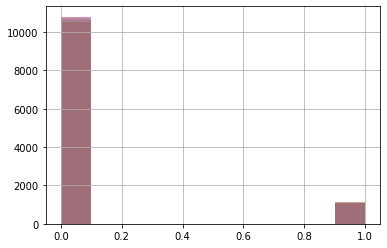

In [9]:
df_folds = pd.read_csv(f'{DATA}/upsample.csv', index_col='image_id',
                       usecols=['image_id', 'fold', 'target'], dtype={'fold': np.byte, 'target': np.byte})

_ = df_folds.groupby('fold').target.hist(alpha=0.4)
df_folds.groupby('fold').target.mean().to_frame('ratio').T

In [10]:
df_test = pd.read_csv(f'{DATA}/test.csv', index_col='image_name')

In [11]:
ds_train, ds_val, ds_test = load_datasets(fold_number)

In [12]:
len(ds_train), len(ds_val), len(ds_test)

(47027, 11889, 10982)

# Model

In [14]:
from efficientnet_pytorch import EfficientNet
from pytorch_lightning.metrics.classification import AUROC
from sklearn.metrics import roc_auc_score

class Model(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EfficientNet.from_pretrained(arch, advprop=True)
        self.net._fc = nn.Linear(in_features=self.net._fc.in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            max_lr=lr,
            epochs=max_epochs,
            optimizer=optimizer,
            steps_per_epoch=int(len(ds_train) / batch_size),
            pct_start=0.1,
            div_factor=10,
            final_div_factor=100,
            base_momentum=0.90,
            max_momentum=0.95,
        )
        return [optimizer], [scheduler]

    def step(self, batch):
        # return batch loss
        x, y  = batch
        y_hat = self(x).flatten()
        y_smo = y.float() * (1 - label_smoothing) + 0.5 * label_smoothing
        loss  = F.binary_cross_entropy_with_logits(y_hat, y_smo.type_as(y_hat),
                                                   pos_weight=torch.tensor(pos_weight))
        return loss, y, y_hat.sigmoid()

    def training_step(self, batch, batch_nb):
        # hardware agnostic training
        loss, y, y_hat = self.step(batch)
        acc = (y_hat.round() == y).float().mean().item()
        tensorboard_logs = {'train_loss': loss, 'acc': acc}
        return {'loss': loss, 'acc': acc, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        loss, y, y_hat = self.step(batch)
        return {'val_loss': loss,
                'y': y.detach(), 'y_hat': y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y = torch.cat([x['y'] for x in outputs])
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        auc = AUROC()(pred=y_hat, target=y) if y.float().mean() > 0 else 0.5 # skip sanity check
        acc = (y_hat.round() == y).float().mean().item()
        print(f"Epoch {self.current_epoch} acc:{acc} auc:{auc}")
        tensorboard_logs = {'val_loss': avg_loss, 'val_auc': auc, 'val_acc': acc}
        return {'avg_val_loss': avg_loss,
                'val_auc': auc, 'val_acc': acc,
                'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        x, _ = batch
        y_hat = self(x).flatten().sigmoid()
        return {'y_hat': y_hat}

    def test_epoch_end(self, outputs):
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        assert len(df_test) == len(y_hat), f"{len(df_test)} != {len(y_hat)}"
        df_test['target'] = y_hat.tolist()
        N = len(glob('submission*.csv'))
        df_test.target.to_csv(f'submission{N}.csv')
        return {'tta': N}

    def train_dataloader(self):
        return DataLoader(ds_train, batch_size=batch_size, num_workers=num_workers,
                          drop_last=True, shuffle=True, pin_memory=False)

    def val_dataloader(self):
        return DataLoader(ds_val, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=False)

    def test_dataloader(self):
        return DataLoader(ds_test, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=False)

In [15]:
checkpoint = sorted(list(SAVE_DIR.iterdir()), key=lambda x: int(x.stem.split('_')[0]))
checkpoint = str(checkpoint[-1]) if len(checkpoint) else None

In [16]:
model = Model()#.load_from_checkpoint(str(checkpoint))

Loaded pretrained weights for efficientnet-b5


tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int8)

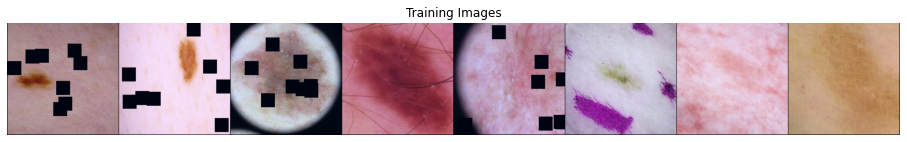

In [17]:
# Plot some training images
import torchvision.utils as vutils
batch, targets = next(iter(model.train_dataloader()))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
_ = plt.imshow(vutils.make_grid(
    batch[:16], nrow=8, padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))

targets[:16].reshape([2, 8]) if len(targets) >= 16 else targets

In [ ]:
# import wandb
# wandb.init(project='melanoma', tags=['lightning'], name='upsampled_full_data_tpu')
# wandb_logger = WandbLogger(project='melanoma', tags=['lightning'], name='upsampled_full_data_tpu')
# wandb.watch(model)

In [ ]:
# # test the same images
# with torch.no_grad():
#     print(model(batch[:16]).reshape([len(targets)//8,8]).sigmoid())
# del batch; del targets

# Train
The Trainer automates the rest.

Trains on 8 TPU cores, GPU or CPU - whatever is available.

In [18]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath=SAVE_DIR /"{02d}_{val_auc:.4f}",
                                                   save_top_k=1, monitor='val_auc', mode='max')
if checkpoint:
    trainer = pl.Trainer(resume_from_checkpoint=checkpoint,
                        default_root_dir=SAVE_DIR,
                        tpu_cores=tpu_cores,
                        gpus=gpus,
                        precision=32, #if gpus else 32,
                        max_epochs=max_epochs,
                        checkpoint_callback=checkpoint_callback
                        # logger=wandb_logger
                        )
else:
    trainer = pl.Trainer(
        default_root_dir=SAVE_DIR,
        tpu_cores=tpu_cores,
        gpus=gpus,
        precision=32, # if gpus else 32,
        max_epochs=max_epochs,
        checkpoint_callback=checkpoint_callback
        #logger=wandb_logger
     )

GPU available: False, used: False
TPU available: True, using: 8 TPU cores
Using native 16bit precision.


In [ ]:
# clean up gpu in case you are debugging 
# import gc
# torch.cuda.empty_cache(); gc.collect()
# torch.cuda.empty_cache(); gc.collect()

In [19]:
trainer.fit(model)

training on 8 TPU cores


KeyboardInterrupt: 